# Model interpretation (random forest)


For tabular data, model interpretation is particularly important.


1) How confident are we in our predictions using a particular row of data?
2) For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
3) Which columns are the strongest predictors, which can we ignore?
4) Which columns are effectively redundant with each other, for purposes of prediction?
4) How do predictions vary, as we vary these columns?

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastbook import (
    cluster_columns,
    Path,
    load_pickle,
    save_pickle,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

from evaluation import m_rmse, r_mse

In [2]:
path = Path('/home/david/.fastai/archive/bluebook-for-bulldozers')
Path.BASE_PATH = path

to = load_pickle(path / "to.pkl")

xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

# additional pre-processing

xs.loc[xs["YearMade"] < 1900, "YearMade"] = 1950
valid_xs.loc[valid_xs["YearMade"] < 1900, "YearMade"] = 1950

In [3]:
def random_forest(
    xs: pd.DataFrame,
    y: pd.Series,
    n_estimators: int = 40,
    max_samples: int = 200_000,
    max_features: float = 0.5,
    min_samples_leaf: int = 5,
    **kwargs
):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True
    ).fit(xs, y)

In [4]:
model = random_forest(xs, y)

m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y)

(0.17087, 0.232547)

### Tree Variance for Prediction Confidence

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? 


One simple way is to use the **standard deviation** of predictions across the trees.

In [5]:
import warnings

# Hide all warnings from sklearn:
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

In [6]:
# Get predictions using the validation set

preds = np.stack([t.predict(valid_xs) for t in model.estimators_])
preds.shape # 40 trees and 7988 auctions (predictions for each one)

(40, 7988)

In [7]:
preds_std = preds.std(0)

In [8]:
preds_std.shape

(7988,)

Here are the standard deviations for the predictions for the first five auctions—that is, the first five rows of the validation set:

In [9]:
preds_std[:5]

array([0.19991518, 0.12746252, 0.11519296, 0.29948162, 0.10878831])

The confidence in predictions is not varying so much. There is a low standard deviation when the trees agree and it's higher when they don't.


This info could be useful in production, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

### Feature importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know how it's making predictions.

In [10]:
def rf_feat_importance(model, df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        {'cols': df.columns, 'importance': model.feature_importances_}
    ).sort_values('importance', ascending=False)

In [11]:
"""The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list.
"""

fi = rf_feat_importance(model, xs)
fi[:10]

,cols,importance
57,YearMade,0.173411
6,ProductSize,0.110315
30,Coupler_System,0.100504
7,fiProductClassDesc,0.070285
54,ModelID,0.053844
65,saleElapsed,0.050676
3,fiSecondaryDesc,0.048737
32,Hydraulics_Flow,0.048496
31,Grouser_Tracks,0.044165
9,ProductGroup,0.030880


In [12]:
# A plot of the feature importances shows the relative importances more clearly
def plot_feature_importance(fi: pd.DataFrame):
    return fi.plot('cols', 'importance', 'barh', figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

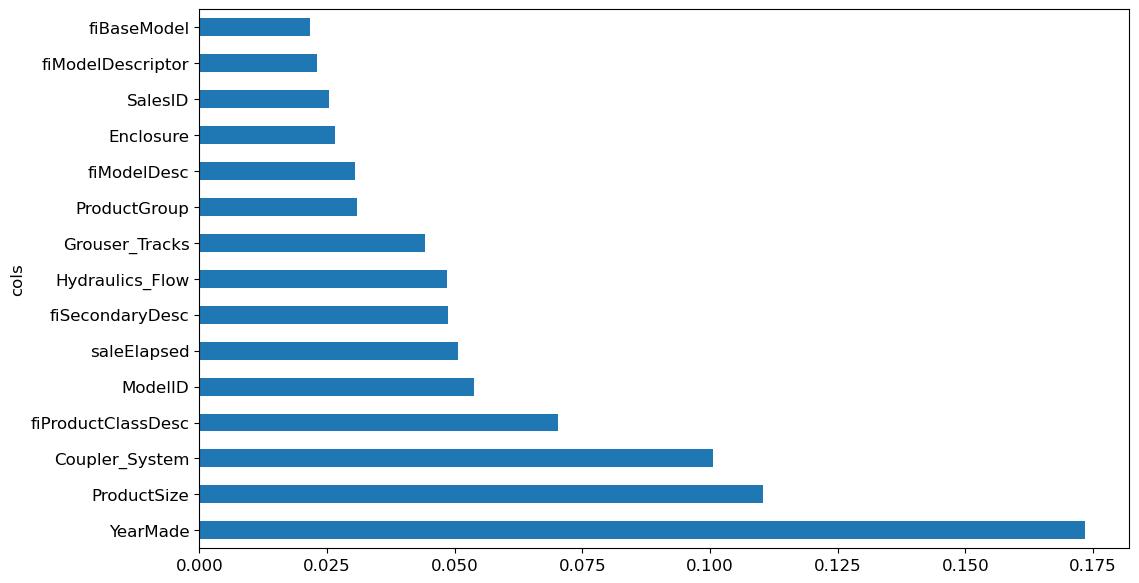

In [13]:
plot_feature_importance(fi[:15])

The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005.

In [14]:
to_keep = fi[fi.importance>0.005].cols
to_keep.tolist(), len(to_keep)

(['YearMade',
  'ProductSize',
  'Coupler_System',
  'fiProductClassDesc',
  'ModelID',
  'saleElapsed',
  'fiSecondaryDesc',
  'Hydraulics_Flow',
  'Grouser_Tracks',
  'ProductGroup',
  'fiModelDesc',
  'Enclosure',
  'SalesID',
  'fiModelDescriptor',
  'fiBaseModel',
  'saleYear',
  'ProductGroupDesc',
  'MachineID',
  'Hydraulics',
  'Drive_System',
  'Tire_Size',
  'Pad_Type'],
 22)

In [15]:
# We train retrain the model only using this subset of columns
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [16]:
model = random_forest(xs_imp, y)

In [17]:
m_rmse(model, xs_imp, y), m_rmse(model, valid_xs_imp, valid_y)

(0.180943, 0.23279)

In [18]:
# Our accuracy is about the same, but we have far fewer columns to study.

len(xs.columns), len(xs_imp.columns)

(66, 22)

<AxesSubplot:ylabel='cols'>

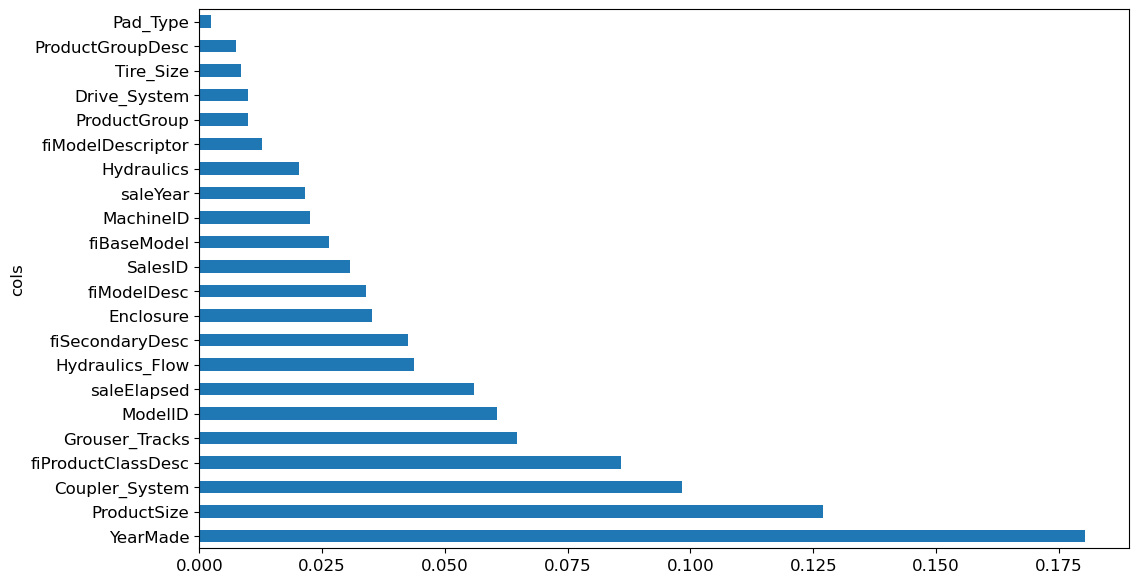

In [19]:
# this also makes our feature importance plot easier to interpret.

plot_feature_importance(rf_feat_importance(model, xs_imp))

### Removing redundant features

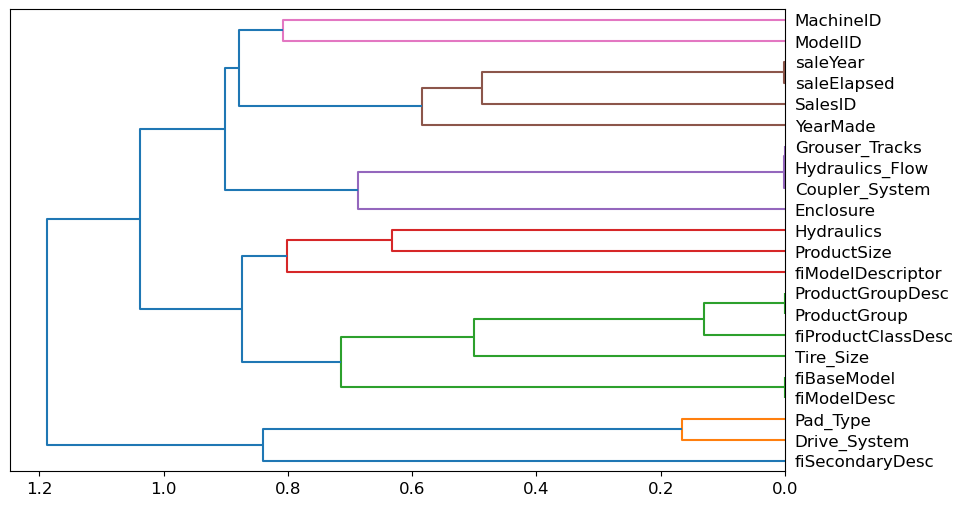

In [20]:
cluster_columns(xs_imp)

The pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left.

Unsurprisingly, the fields `ProductGroup` and `ProductGroupDesc` were merged quite early, as were `saleYear` and `saleElapsed` and `fiModelDesc` and `fiBaseModel`.

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`.

In [21]:
def get_oob(df: pd.DataFrame):
    m = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=15,
        max_samples=50_000,
        max_features=0.5,
        n_jobs=-1,
        oob_score=True
    )

    m.fit(df, y)
    return m.oob_score_

In [22]:
# baseline
get_oob(xs_imp)

0.8772984296431152

In [23]:
redundant_columns = (
    'saleYear',
    'saleElapsed',
    'ProductGroupDesc',
    'ProductGroup',
    'fiModelDesc',
    'fiBaseModel',
    'Hydraulics_Flow',
    'Grouser_Tracks',
    'Coupler_System'
)

{
    f"{column} deleted": get_oob(xs_imp.drop(column, axis=1)) for column in redundant_columns
}

{'saleYear deleted': 0.8763915768873893,
 'saleElapsed deleted': 0.8719931967483294,
 'ProductGroupDesc deleted': 0.8764692447771175,
 'ProductGroup deleted': 0.8769843404597039,
 'fiModelDesc deleted': 0.8757847060118639,
 'fiBaseModel deleted': 0.8760309873191133,
 'Hydraulics_Flow deleted': 0.8772276512134235,
 'Grouser_Tracks deleted': 0.8771545868834103,
 'Coupler_System deleted': 0.8774064551829076}

In [24]:
# Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier.
to_drop = ["saleElapsed", "ProductGroupDesc", "fiModelDesc", "Grouser_Tracks"]
get_oob(xs_imp.drop(to_drop, axis=1))

0.8705348477793151

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, 
and save them.

In [25]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

save_pickle(path / "xs_final.pkl", xs_final)
save_pickle(path / "valid_xs_final.pkl", valid_xs_final)

In [26]:
# Check RMSE again

model = random_forest(xs_final, y)
m_rmse(model, xs_final, y), m_rmse(model, valid_xs_final, valid_y), 

(0.190006, 0.233577)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model.

### Partial dependence

The two most important predictors are `ProductSize` and `YearMade`. We'd like to understand the relationship between these predictors and sale price. Check frequency of categories of product size.

([<matplotlib.axis.YTick at 0x7f22a232a0d0>,
 [Text(0, 0, '#na#'),
  Text(0, 1, 'Large'),
  Text(0, 2, 'Large / Medium'),
  Text(0, 3, 'Medium'),
  Text(0, 4, 'Small'),
  Text(0, 5, 'Mini'),
  Text(0, 6, 'Compact')])

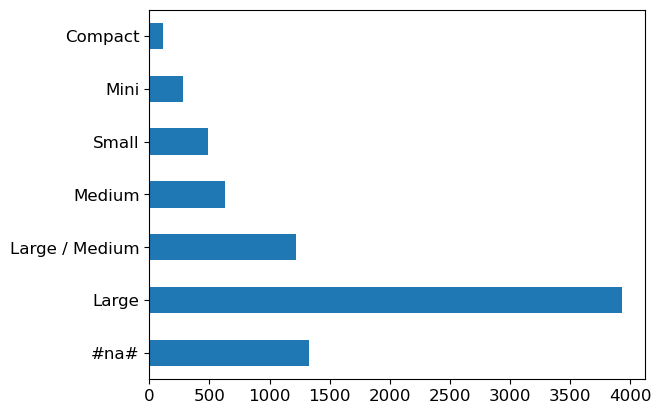

In [27]:
p = valid_xs_final["ProductSize"].value_counts(sort=False).plot.barh()
classes = to.classes["ProductSize"]
plt.yticks(ticks=range(len(classes)), labels=classes)

Let's do the same thing for YearMade. Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins.

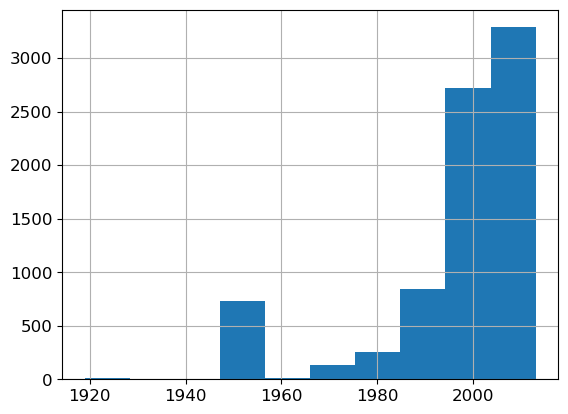

In [28]:
ax = valid_xs_final["YearMade"].hist()

Most of the data is from after 1990. 

**Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?**

For instance, how does `YearMade` impact sale price, all other things being equal?

To do that...replace every single value in the `YearMade` column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only `YearMade` (even if it does so by averaging over some imagined records where we assign a `YearMade` value that might never actually exist alongside some other values).



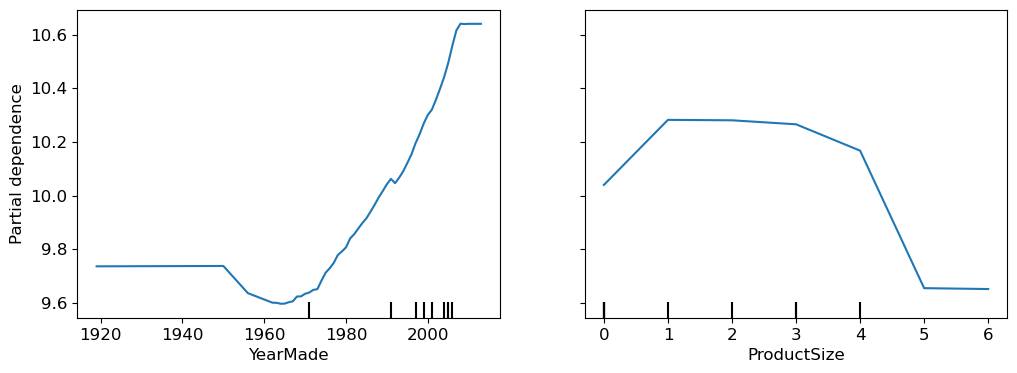

In [29]:
features_info = {
    "features": ["YearMade", "ProductSize"],
    "kind": "average",
}
fig, ax = plt.subplots(figsize=(12, 4))

display = PartialDependenceDisplay.from_estimator(
    model,
    valid_xs_final,
    **features_info,
    ax=ax,
)

Looking first of all at the `YearMade` plot, and specifically at the section covering the years after 1990 (since as we noted this is where we have the most data), we can see a nearly linear relationship between year and price.


The `ProductSize` partial plot is a bit concerning. It shows that the final group, which we saw is for missing values, has the lowest price. To use this insight in practice, we would want to find out why it's missing so often, and what that means.

Missing values can sometimes be useful predictors—it entirely depends on what causes them to be missing. Sometimes, however, they can indicate data leakage.


### Data Leakage

"The introduction of information about the target of a data mining problem, which should not be legitimately available to mine from. A trivial example of leakage would be a model that uses the target itself as an input, thus concluding for example that 'it rains on rainy days'."


Data leakage is subtle and can take many forms. In particular, missing values often represent data leakage.

The most practical and simple approaches to identifying data leakage, which are to build a model and then:

1) Check whether the accuracy of the model is too good to be true.
2) Look for important predictors that don't make sense in practice.
3) Look for partial dependence plot results that don't make sense in practice.

### Tree Interpreter

In [32]:
!pip install treeinterpreter waterfallcharts

  Using cached treeinterpreter-0.2.3-py2.py3-none-any.whl (6.0 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3388 sha256=23c9d4047b5682a73ecedc9fec6ed4ef0ca78da80f990ce54d0ddb9234c9948f
  Stored in directory: /home/david/.cache/pip/wheels/5f/d9/1f/1321911b4ad290d225ba37873323fb3ec7980d6efc80cf8e9c
Successfully built waterfallcharts


In [33]:
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?

We will answer it using the treeinterpreter library.


For instance, let's say we are looking at some particular item at auction. Our model might predict that this item will be very expensive, and we want to know why. So, we take that one row of data and put it through the first decision tree, looking to see what split is used at each point throughout the tree. For each split, we see what the increase or decrease in the addition is, compared to the parent node of the tree. We do this for every tree, and add up the total change in importance by split variable.

In [34]:
row = valid_xs_final.iloc[:5]

In [35]:
prediction, bias, contributions = treeinterpreter.predict(model, row.values)

"""
- prediction is simply the prediction that the random forest makes. 

- bias is the prediction based on taking the mean of the dependent variable (i.e., the model that is the root of every tree). 

- contributions is the most interesting bit—it tells us the total change in predicition due to each of the independent variables. Therefore, the sum of contributions plus bias must equal the prediction, for each row.
"""

In [36]:
prediction[0], bias[0], contributions[0].sum()

(array([9.98447604]), 10.104513595136046, -0.12003755712525568)

A good way to display the contributions is with a waterfall plot. 

It shows how the positive and negative contributions from all the independent variables sum up to create the final prediction.

<module 'matplotlib.pyplot' from '/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/matplotlib/pyplot.py'>

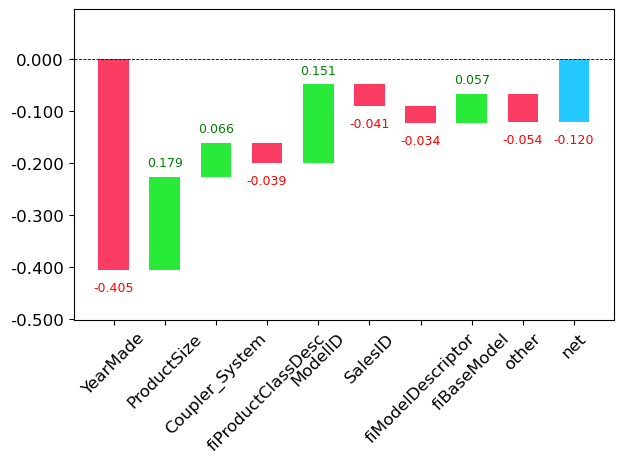

In [37]:
waterfall(
    valid_xs_final.columns,
    contributions[0],
    threshold=0.08, 
    rotation_value=45,
    formatting='{:,.3f}'
)